# Enable Auto-Mixed Precision for Transfer Learning with TensorFlow

This notebook performs the following steps:

- Enable auto-mixed precision with a single-line change.
- Transfer-Learning for Image Classification using [TensorFlow Hub's](https://www.tensorflow.org/hub) ResNet50v1.5 pretrained model.
- Export the fine-tuned model in the [SavedModel](https://www.tensorflow.org/guide/saved_model) format.
- Optimize the SavedModel for faster inference.
- Serve the SavedModel using [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).

In [1]:
import config_setup

arch = config_setup.arch_checker().arch
print("Arch: ", arch)

TensorTlow version:  2.9.1
MKL enabled : True
scikit learn Version:  1.1.1
neural_compressor version 1.13
Arch:  BDW|CORE|ATOM


In [61]:
# Importing libraries
import os
import numpy as np
import time
import PIL.Image as Image
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
import requests
from copy import deepcopy
import wandb
from wandb.keras import WandbMetricsLogger
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, roc_curve, auc
import matplotlib.pyplot as plt
import itertools
print("We are using Tensorflow version: ", tf.__version__)

We are using Tensorflow version:  2.9.1


In [3]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

### Identifying supported ISA

We identify the underlying supported ISA to determine whether to enable auto-mixed precision to leverage higher performance benefits for training and inference as accelerated by the 4th Gen Intel® Xeon® scalable processor (codenamed Sapphire Rapids).

### Transfer Learning for Image Classification with TensorFlow

In this section, we use [TensorFlow Hub's](https://www.tensorflow.org/hub) pretrained [ResNet50v1.5 pretrained model](https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5) originally trained on the ImageNet dataset and perform transfer learning to fine-tune the model for your own image classes.

Source: https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub

In this example, we use the **TensorFlow Flower dataset**

Loading the data in a *tf.data.Dataset* format.<br />
We use a Batch Size of 512 images each of shape 224 x 224 x 3.

In [4]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
data_root = ('./dataset/datafile/')

batch_size = 64
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

class_names = np.array(train_ds.class_names)
print("The crop weed dataset has " + str(len(class_names)) + " classes: ", class_names)

Found 1302 files belonging to 2 classes.
Using 1042 files for training.
Found 1302 files belonging to 2 classes.
Using 260 files for validation.
The crop weed dataset has 2 classes:  ['crop' 'weed']


2023-03-27 20:18:27.477750: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 20:18:27.478955: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 


Image Pre-processing (Normalization between 0 and 1) and using buffered prefetching to avoid I/O blocking issues.

Reference: https://www.tensorflow.org/guide/data_performance#prefetching

In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64,)


2023-03-27 20:18:32.061348: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


**Simple Transfer Learning:**<br />
    1. *Select a pre-trained model from TensorFlow Hub*.<br />
    2. *Retrain the top (last) layer to recognize the classes from your custom dataset*.<br /><br />

We use a **headless ResNet50v1.5 pretrained model** (without the classification layer). Any compatible image feature vector model from TF-Hub (https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) can be used here.

In [7]:
resnet_feature_vector = "https://tfhub.dev/google/imagenet/resnet_v1_101/feature_vector/5"

feature_extractor_model = resnet_feature_vector

Create the feature extractor by wrapping the pre-trained model as a Keras layer with **hub.KerasLayer**. Use the ***trainable=False*** argument to freeze the variables, so that the training only modifies the new classifier layer:

In [8]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

feature_batch = feature_extractor_layer(image_batch)

2023-03-27 20:18:36 [INFO] Using /tmp/tfhub_modules to cache modules.


Attach the last fully connected classification layer in a **tf.keras.Sequential** model.

In [9]:
num_classes = len(class_names)

fp32_model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

bf16_model = deepcopy(fp32_model)
# if arch == 'BDW|CORE|ATOM':
#     # Create a deep copy of the model to train the bf16 model separately to compare accuracy
#     bf16_model = deepcopy(fp32_model)

fp32_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              42605504  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

In order to measure the training throughput, we define the following custom callback. For more information on callbacks, refer to https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback.

In [10]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
        self.throughput = []

    def on_batch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_batch_end(self, batch, logs={}):
        total_time = time.time() - self.epoch_time_start
        self.times.append(total_time)
        self.throughput.append(batch_size/total_time)

#### Compile and train the model

In [11]:
fp32_model.compile(
  optimizer=tf.keras.optimizers.SGD(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [12]:
train_throughput_list = []

#### Train without auto-mixed precision (float32)

In [13]:
NUM_EPOCHS = 50

In [14]:
configs = dict(
    num_classes = num_classes,
    shuffle_buffer = 42,
    batch_size = batch_size,
    image_size = 224,
    image_channels = 3,
    earlystopping_patience = 3,
    learning_rate = 1e-3,
    epochs = NUM_EPOCHS
)

In [17]:
# Initialize a W&B run
run = wandb.init(
    project = "Automated-Weed-Detection-AMP",
    config = configs
)

time_callback = TimeHistory()
history = fp32_model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS, callbacks=[time_callback, WandbMetricsLogger(log_freq=10)])
avg_throughput = sum(time_callback.throughput)/len(time_callback.throughput)
print("Avg Throughput: " + str(avg_throughput) + " imgs/sec")
train_throughput_list.append(avg_throughput)

batch/acc,▁
batch/batch_step,▁
batch/learning_rate,▁
batch/loss,▁
batch/acc,0.5
batch/batch_step,0
batch/learning_rate,0.01
batch/loss,1.87926


Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 0.8942 - acc: 0.5048

/home/mnitin59/anaconda3/envs/aikit-tf/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


17/17 [==============================] - 67s 4s/step - loss: 0.8942 - acc: 0.5048 - val_loss: 0.6817 - val_acc: 0.5923
Epoch 2/50
17/17 [==============================] - 66s 4s/step - loss: 0.7983 - acc: 0.5221 - val_loss: 0.6750 - val_acc: 0.5462
Epoch 3/50
17/17 [==============================] - 74s 4s/step - loss: 0.7444 - acc: 0.5441 - val_loss: 0.6754 - val_acc: 0.5692
Epoch 4/50
17/17 [==============================] - 71s 4s/step - loss: 0.7490 - acc: 0.5125 - val_loss: 0.6661 - val_acc: 0.6846
Epoch 5/50
17/17 [==============================] - 66s 4s/step - loss: 0.7121 - acc: 0.5441 - val_loss: 0.6726 - val_acc: 0.6000
Epoch 6/50
17/17 [==============================] - 67s 4s/step - loss: 0.7040 - acc: 0.5614 - val_loss: 0.6675 - val_acc: 0.6577
Epoch 7/50
17/17 [==============================] - 66s 4s/step - loss: 0.6988 - acc: 0.5384 - val_loss: 0.6562 - val_acc: 0.7308
Epoch 8/50
17/17 [==============================] - 67s 4s/step - loss: 0.7088 - acc: 0.5557 - val_lo

### Enabling auto-mixed precision with `tf.config` API

In this section, we show how to enable the auto-mixed precision using the `tf.config` API. Enabling this API will automatically convert the pre-trained model to use the bfloat16 datatype for computation resulting in an increased training throughput on the latest Intel® Xeon® scalable processor.

You can also print the following to see whether the auto-mixed precision has been enabled.

_Note: We only enable the auto-mixed precision if the underlying system is the 4th Gen Intel® Xeon® scalable processor (codenamed Sapphire Rapids)_

In [18]:
if arch == 'BDW|CORE|ATOM':
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision_onednn_bfloat16':True})
    print(tf.config.optimizer.get_experimental_options())

{'disable_model_pruning': False, 'disable_meta_optimizer': False}


#### Compile and train the model with auto-mixed precision (bfloat16)

In [19]:
if arch == 'BDW|CORE|ATOM':
    # Initialize a W&B run
    run = wandb.init(
        project = "Automated-Weed-Detection-AMP",
        config = configs
    )
    # Compile
    bf16_model.compile(
      optimizer=tf.keras.optimizers.SGD(),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['acc'])
    
    # Train
    NUM_EPOCHS = 50
    time_callback = TimeHistory()
    history = bf16_model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS, callbacks=[time_callback, WandbMetricsLogger(log_freq=10)])
    avg_throughput = sum(time_callback.throughput)/len(time_callback.throughput)
    print("Avg Throughput: " + str(avg_throughput) + " imgs/sec")
    train_throughput_list.append(avg_throughput)
    
    model = bf16_model
else:
    model = fp32_model

batch/acc,▃▂▂▂▁▄▂▂▂▅▃▄▆▅▅▆▆▆▆▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▇▇█▆▇▇▆▆▆▅▄▅▄▃▃▄▃▂▃▃▃▁▂▃▁▁▂▂▁▁▂▂▁▁▂▃▁▂
epoch/acc,▁▁▂▁▂▂▂▂▃▃▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▂▁▁
epoch/val_acc,▂▁▁▃▃▄▅▆▇███████████████████████████████
epoch/val_loss,███████▇▇▆▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/acc,0.94602


Epoch 1/50


/home/mnitin59/anaconda3/envs/aikit-tf/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


17/17 [==============================] - 72s 4s/step - loss: 1.1789 - acc: 0.4818 - val_loss: 0.6877 - val_acc: 0.5731
Epoch 2/50
17/17 [==============================] - 65s 4s/step - loss: 0.8499 - acc: 0.5163 - val_loss: 0.6670 - val_acc: 0.6154
Epoch 3/50
17/17 [==============================] - 74s 4s/step - loss: 0.8209 - acc: 0.4990 - val_loss: 0.6848 - val_acc: 0.5615
Epoch 4/50
17/17 [==============================] - 69s 4s/step - loss: 0.7542 - acc: 0.5365 - val_loss: 0.6808 - val_acc: 0.5577
Epoch 5/50
17/17 [==============================] - 69s 4s/step - loss: 0.7360 - acc: 0.5413 - val_loss: 0.6775 - val_acc: 0.6115
Epoch 6/50
17/17 [==============================] - 73s 4s/step - loss: 0.7264 - acc: 0.5470 - val_loss: 0.6684 - val_acc: 0.6615
Epoch 7/50
17/17 [==============================] - 74s 4s/step - loss: 0.7094 - acc: 0.5461 - val_loss: 0.6583 - val_acc: 0.7962
Epoch 8/50
17/17 [==============================] - 75s 4s/step - loss: 0.7182 - acc: 0.5432 - val_lo

Now, let's compare the throughput achieved with and without auto-mixed precision enabled.

[21.73333016090273, 20.161133137526804]
Speedup :  0.9276596356041082


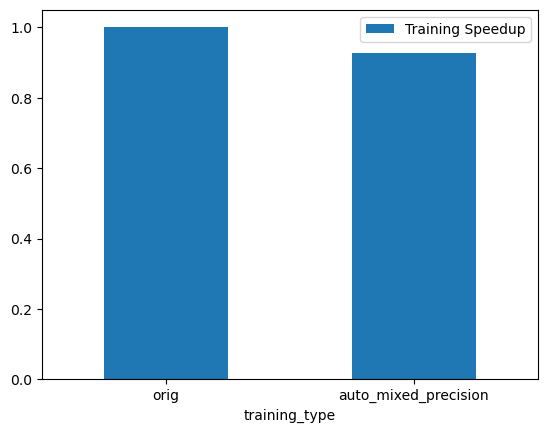

In [20]:
if arch == 'BDW|CORE|ATOM':
    import pandas as pd
    print(train_throughput_list)
    speedup = float(train_throughput_list[1])/float(train_throughput_list[0])
    print("Speedup : ", speedup)
    df = pd.DataFrame({'training_type':['orig', 'auto_mixed_precision'], 'Training Speedup':[1, speedup]})
    ax = df.plot.bar( x='training_type', y='Training Speedup', rot=0)

### Export the model in the SavedModel format

Now that you've trained the model, export it as a SavedModel for reusing it later.

In [21]:
export_path = "models/resnet101_cropweed_model"
model.save(export_path)

export_path

'models/resnet101_cropweed_model'

Let's measure the performance of the model we just saved using the `tf_benchmark.py` script that runs inference on dummy data.

In [35]:
!python scripts/tf_benchmark.py --model_path models/resnet101_cropweed_model --num_warmup 5 --num_iter 50 --precision float32 --batch_size 32 --disable_optimize

2023-03-27 22:34:37.712789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 22:34:37.762528: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 
2023-03-27 22:34:53.096524: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 
2023-03-27 22:34:53.096930: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-27 22:34:56.608597: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 
2023-03-27 22:34:56.608823: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
Find a possible input node: {'nod

### Optimize the SavedModel for faster inference

To get a good performance on your (re)trained model for inference, some inference optimizations are required.
In this section, we will guide you how to optimize a pre-trained model for better inference performance using the `freeze_optimize_v2.py` script that we put together using standard TensorFlow routines to optimize the model.
Those optimizations includes:

- Converting variables to constants
- Removing training-only operations like checkpoint saving
- Stripping out parts of the graph that are never reached
- Removing debug operations like CheckNumerics
- Folding batch normalization ops into the pre-calculated weights
- Fusing common operations into unified versions

The input to this script is the directory of original saved model, and output of this script is the directory of optimzed model. Users don't need to change below command in this tutorial, but need to put related directories after "--input_saved_model_dir" and "--output_saved_model_dir" for other pre-trained models.

In [36]:
!python scripts/freeze_optimize_v2.py --input_saved_model_dir=models/resnet101_cropweed_model --output_saved_model_dir=models/resnet101_optimized_model

2023-03-27 22:36:35.182994: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 22:36:35.185740: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 
2023-03-27 22:36:38.989455: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 
2023-03-27 22:36:38.989716: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-27 22:36:44.344824: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 
2023-03-27 22:36:44.345039: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
Instructions for updating:
Use `t

Now that we have saved the optimized model, let's measure its performance using our benchmarking script.

In [38]:
!python scripts/tf_benchmark.py --model_path models/resnet101_optimized_model --num_warmup 5 --num_iter 50 --precision float32 --batch_size 32

2023-03-27 22:39:29 [WARNING] SavedModel saved prior to TF 2.5 detected when loading Keras model. Please ensure that you are saving the model with model.save() or tf.keras.models.save_model(), *NOT* tf.saved_model.save(). To confirm, there should be a file named "keras_metadata.pb" in the SavedModel directory.
2023-03-27 22:39:29 [WARNING] SavedModel saved prior to TF 2.5 detected when loading Keras model. Please ensure that you are saving the model with model.save() or tf.keras.models.save_model(), *NOT* tf.saved_model.save(). To confirm, there should be a file named "keras_metadata.pb" in the SavedModel directory.
2023-03-27 22:39:29.724844: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Instructions for updating:
This fu

**Let's compare the speedup obtained with the optimized model.**

`plot.py` is a python script that creates a plot of the throughput values for inference with the original and the optimized model.

In [40]:
!python scripts/plot.py

Throughput list:  [40.3336740958423, 51.99652304653568, 24.410872197613376, 25.068498141155832, 28.338707572065836]
Speedup :  1.2891591012259311


### TensorFlow Serving

In this section, we will initialize and run TensorFlow Serving natively to serve our retrained model.

In [42]:
!mkdir serving
!cp -r models/resnet101_optimized_model serving/1

mkdir: cannot create directory ‘serving’: File exists


In [43]:
os.environ["MODEL_DIR"] = os.getcwd() + "/serving"

This is where we start running TensorFlow Serving and load our model. After it loads we can start making inference requests using REST. There are some important parameters:
- **rest_api_port**: The port that you'll use for REST requests.
- **model_name**: You'll use this in the URL of REST requests. It can be anything.
- **model_base_path**: This is the path to the directory where you've saved your model.

In [44]:
%%bash --bg
nohup tensorflow_model_server --rest_api_port=8501 --model_name=rn50 --model_base_path=${MODEL_DIR} > server.log 2>&1

In [45]:
!tail server.log

**Prepare the testing data for prediction**

In [46]:
for image_batch, labels_batch in val_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break
test_data, test_labels = image_batch.numpy(), labels_batch.numpy()

(64, 224, 224, 3)
(64,)


First, let's take a look at a random example from our test data.

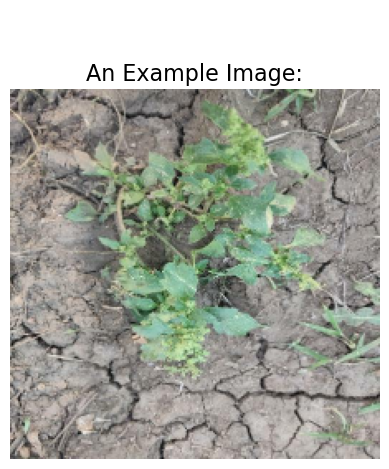

In [47]:
import matplotlib.pyplot as plt

def show(idx, title):
    plt.figure()
    plt.imshow(test_data[idx])
    plt.axis('off')
    plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,test_data.shape[0]-1)
show(rando, 'An Example Image:')

#### Make a request to your model in TensorFlow Serving

Now let's create the JSON object for a batch of three inference requests, and see how well our model recognizes things:

In [48]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": test_data[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... 9980164, 0.7038618326187134, 0.7038618326187134]]]]}


#### Make REST requests

We'll send a predict request as a POST to our server's REST endpoint, and pass it three examples.

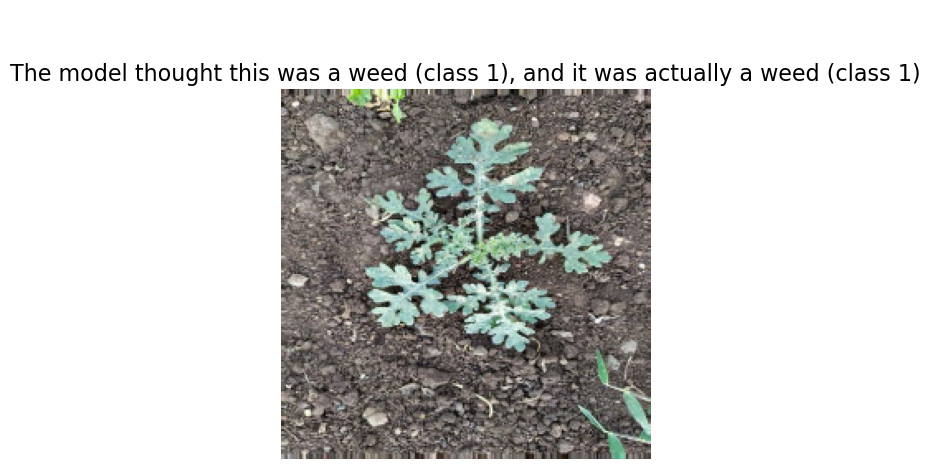

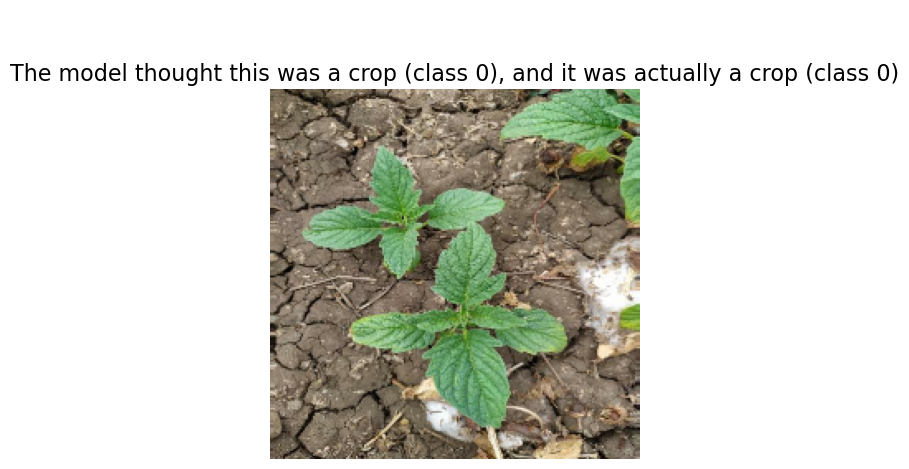

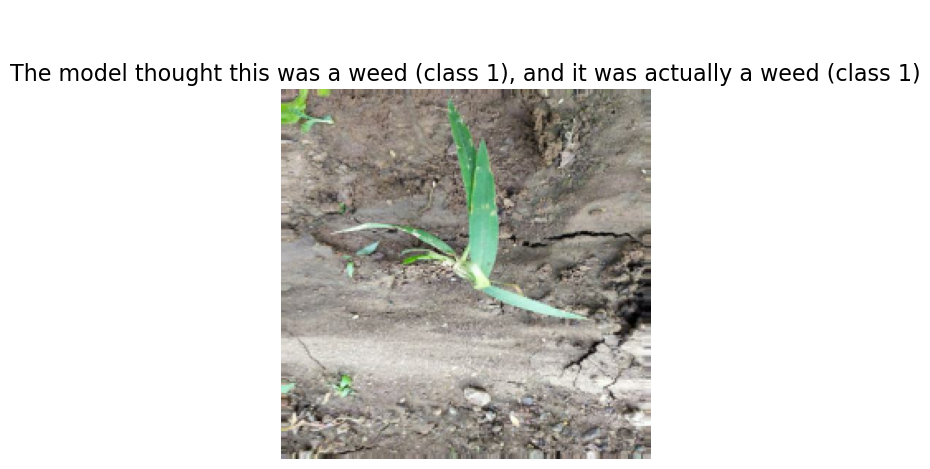

In [49]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/rn50:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,3):
    show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
        class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[i]], test_labels[i]))

In [57]:
import time

start_time = time.time()
test_preds = model.predict(test_data)
end_time = time.time()

total_time = end_time - start_time
latency_speed = total_time / len(test_data)

print("Total time taken: {:.2f} seconds".format(total_time))
print("Latency speed: {:.2f} seconds per sample".format(latency_speed))

2/2 [==============================] - 3s 2s/step
Total time taken: 3.32 seconds
Latency speed: 0.05 seconds per sample


In [65]:
# Convert the predictions from probabilities to class labels
test_preds_classes = np.argmax(test_preds, axis=-1)

# Print evaluation metrics
print("Classification Report:\n", classification_report(test_labels, test_preds_classes))
print("Cohen's Kappa:", cohen_kappa_score(test_labels, test_preds_classes))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        31

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64

Cohen's Kappa: 1.0


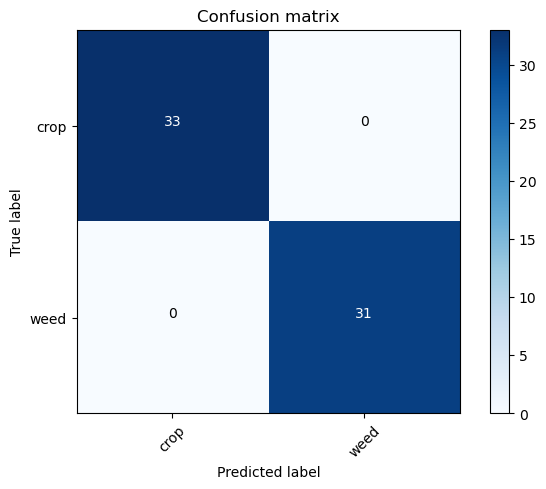

In [66]:
# Plot the confusion matrix
cm = confusion_matrix(test_labels, test_preds_classes)
classes = ['crop', 'weed']
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


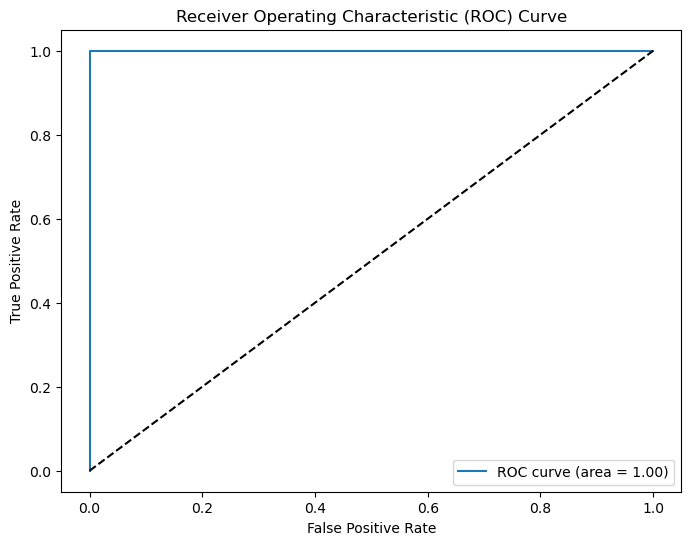

In [64]:
# Compute fpr, tpr, and auc
fpr, tpr, _ = roc_curve(test_labels, test_preds[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the AUC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()